# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 5. Import the necessary packages

In [7]:
import torch
from collections import deque
from matplotlib import pyplot as plt
import time

from itertools import count
import datetime

from ddpg import DDPG, ReplayBuffer
%matplotlib inline

### 6. Hyper Parameters

In [8]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BUFFER_FILL = int(1e4) # How much of the buffer should be filled before learning
CACHE_SIZE = int(1e3)
NUM_UPDATES_CACHE = 2 # How many times to update from cache buffer
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 20       # timesteps between updates
NUM_UPDATES = 15        # num of update passes when updating
EPSILON = 1.0           # epsilon for the noise process added to the actions
EPSILON_DECAY = 1e-6    # decay for epsilon above
NOISE_SIGMA = 0.05

fc1_units=96
fc2_units=96

random_seed=23
RECREATE_EVERY=1 # Recreate agent models with new set of random weights

In [9]:
def store(buffers, states, actions, rewards, next_states, dones, timestep):
    memory, cache = buffers
    for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
        memory.add(state, action, reward, next_state, done)
        cache.add(state, action, reward, next_state, done)
store

<function __main__.store(buffers, states, actions, rewards, next_states, dones, timestep)>

In [10]:
def learn(agent, buffers, timestep, i_episode):
    memory, cache = buffers
    if len(memory) > BUFFER_FILL and timestep % UPDATE_EVERY == 0: 
        for _ in range(NUM_UPDATES):
            experiences = memory.sample()
            agent.learn(experiences, GAMMA)
        for _ in range(NUM_UPDATES_CACHE):
            experiences = cache.sample()
            agent.learn(experiences, GAMMA)
    elif timestep == 0 and i_episode % RECREATE_EVERY == 0:        
        agent.reset()
    
learn

<function __main__.learn(agent, buffers, timestep, i_episode)>

### 6. Train the agent

In [11]:
avg_over = 100
print_every = 50

def ddpg(agent, buffers, n_episodes=200, stopOnSolved=True):
    scores_deque = deque(maxlen=avg_over)
    scores_global = []
    average_global = []
    min_global = []    
    best_avg = -np.inf

    tic = time.time()
    print('\rNo,Score,  Avg,  Min, Time')
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        
        score_average = 0
        timestep = time.time()
        for t in count():
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished            
            store(buffers, states, actions, rewards, next_states, dones, t)
            learn(agent, buffers, t, i_episode)
            states = next_states                               # roll over states to next time step
            scores += rewards                                  # update the score (for each agent)            
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        score = np.max(scores)        
        scores_deque.append(score)
        score_average = np.mean(scores_deque)
        scores_global.append(score)
        average_global.append(score_average)  
        min_global.append(np.min(scores))  
        
        if i_episode % print_every == 0:
            agent.save('./')
            print('\r {}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'\
              .format(str(i_episode).zfill(3), score, score_average, 
                      np.min(scores), time.time() - timestep), end="\n")
        if  stopOnSolved and score_average > 0.5:            
            toc = time.time()
            print('\nSolved in {:d} episodes!\tAvg Score: {:.2f}, time: {}'.format(i_episode, score_average, toc-tic))
            agent.save('./'+str(i_episode)+'_')
            break
     
    print('End: ',datetime.datetime.now())
    return scores_global, average_global, min_global

ddpg

<function __main__.ddpg(agent, buffers, n_episodes=200, stopOnSolved=True)>

In [12]:
# Create new empty buffers to start training from scratch
buffers = [ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed),
           ReplayBuffer(action_size, CACHE_SIZE, BATCH_SIZE, random_seed)]
agent = DDPG(state_size=state_size, action_size=action_size, random_seed=23, 
              fc1_units=96, fc2_units=96)
scores, averages, minima = ddpg(agent, buffers, n_episodes=2000)

No,Score,  Avg,  Min, Time
 050, 0.00, 0.03, -0.01, 0.29
 100, 0.09, 0.02, 0.00, 0.07
 150, 0.00, 0.02, -0.01, 0.05
 200, 0.10, 0.02, 0.09, 0.15
 250, 0.00, 0.02, -0.01, 0.30
 300, 0.00, 0.01, -0.01, 0.29
 350, 0.00, 0.00, -0.01, 0.30
 400, 0.00, 0.00, -0.01, 0.32
 450, 0.00, 0.00, -0.01, 0.29
 500, 0.00, 0.00, -0.01, 0.30
 550, 0.00, 0.00, -0.01, 0.32
 600, 0.00, 0.00, -0.01, 0.30
 650, 0.00, 0.00, -0.01, 0.31
 700, 0.09, 0.02, 0.00, 0.61
 750, 0.00, 0.04, -0.01, 0.29
 800, 0.00, 0.06, -0.01, 0.31
 850, 0.00, 0.04, -0.01, 0.29
 900, 0.00, 0.00, -0.01, 0.31
 950, 0.00, 0.01, -0.01, 0.30
 1000, 0.10, 0.02, 0.09, 1.26
 1050, 0.00, 0.02, -0.01, 0.29
 1100, 0.00, 0.01, -0.01, 0.29
 1150, 0.00, 0.01, -0.01, 0.31
 1200, 0.10, 0.02, -0.01, 0.96
 1250, 0.00, 0.06, -0.01, 0.31
 1300, 0.10, 0.08, -0.01, 0.62
 1350, 0.10, 0.05, -0.01, 0.61
 1400, 0.00, 0.02, -0.01, 0.57
 1450, 0.00, 0.03, -0.01, 0.58
 1500, 0.10, 0.07, -0.01, 0.95
 1550, 0.00, 0.11, -0.01, 0.33
 1600, 0.00, 0.10, -0.01, 0.30
 165

### 7. Generating plots

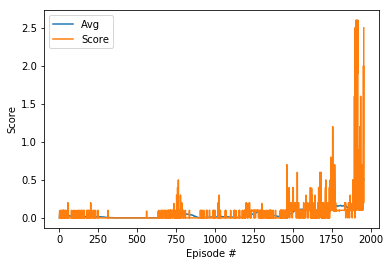

In [13]:
plt.plot(np.arange(1, len(averages)+1), averages)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['Avg', 'Score'], loc='upper left')
plt.show()